# Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)

Картунчиков Артем ББМО-01-23

In [22]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [23]:
# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

test_images = test_images / 255.0

test_labels = to_categorical(test_labels, num_classes=10)

model = tf.keras.models.load_model('mnist_model.h5')

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.9715 - loss: 0.0998
Test accuracy on clean images: 0.9754999876022339


Картунчиков Артем ББМО-01-23

In [24]:
!pip install foolbox


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

image = tf.convert_to_tensor(test_images[2], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

attack = fb.attacks.LinfPGD(steps=10)
print(label)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

tf.Tensor(7, shape=(), dtype=int64)


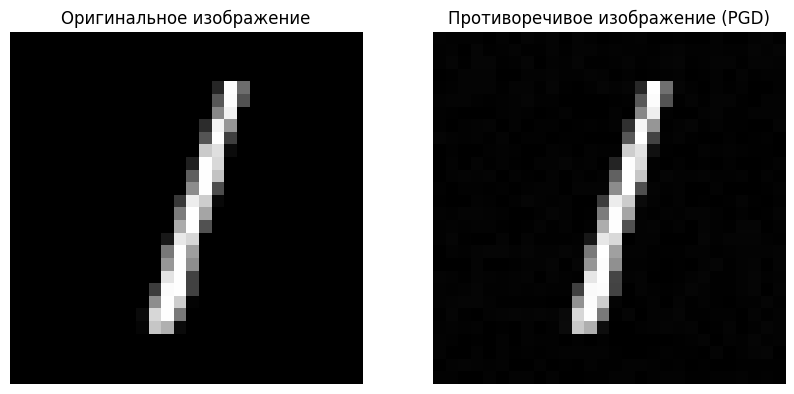

In [26]:
# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

In [27]:
# Создание набора противоречивых примеров
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.4475 - loss: 2.1776
Accuracy on adversarial examples (PGD): 0.5062000155448914


# Вывод:
Точность модели на атакованных примерах снизилась до примерно 50%, по сравнению с точностью на оригинальных данных, в зависимости от параметров силы и количества шагов атаки.

Такое снижение точности свидетельствует о частичной уязвимости модели перед целенаправленными искажениями, созданными методом Projected Gradient Descent (PGD). Это подчеркивает необходимость разработки более устойчивых архитектур и методов защиты, чтобы повысить надежность модели в условиях реальных атак.